# Introduction: Agents.jl basics

This course introduces the [Agents.jl](https://juliadynamics.github.io/Agents.jl/stable/) Julia package for agent based modelling. The notebook is created by [Alejandra Ramirez](https://github.com/MA-Ramirez)
and George Datseris.

Agent based modelling are simulations where autonomous agents react to their environment and interact with each other given a predefined set of rules. 
These rules are formulated based on explicit statements rather than mathematical equations (such as: “If condition X is fulfilled, do action Y, and then perform operation Z on all nearby agents”).

_from Datseris & Parlitz. (2022)_

**Versions**: please ensure you have these packages installed with these or later versions:

In [1]:
import Pkg
Pkg.status(["Agents", "CairoMakie", "GLMakie", "InteractiveDynamics"])

Status `C:\Users\gd419\.julia\environments\v1.8\Project.toml`


  [46ada45e] Agents v5.8.0 `C:\Users\gd419\.julia\dev\Agents`
  [13f3f980] CairoMakie v0.10.2
  [e9467ef8] GLMakie v0.8.2
  [ec714cd0] InteractiveDynamics v0.22.1 `C:\Users\gd419\.julia\dev\InteractiveDynamics`


# Super-brief intro to Types in Julia

(Composite) Types in Julia is how you make your own data structures. They are made with the following syntax:

In [32]:
mutable struct MyDataStructure
    a::Int # explicitly annotate the type of field `a`
    b      # do not annotate any type for field `b`
end

To initialize such a type, you call its name as a function with inputs the fields of the type (in order they were defined)

In [34]:
mystruct = MyDataStructure(1, "test")

MyDataStructure(1, "test")

Using such user-defined composite types is very similar to object oriented languages. You retrieve the contained fields with the `type.fieldname` syntax, like so:

In [35]:
mystruct.a

1

In [36]:
mystruct.b

"test"

_(We need this super basic introduction to using user-defined structures, because agents in Agents.jl are user-defined structures just like the one above)_

# Agents.jl: basic modelling

In this block we will go through a basic tutorial for Agents.jl. Another basic introduction can be found [online based on the Schelling model](https://juliadynamics.github.io/Agents.jl/stable/examples/schelling/).

To set up an ABM simulation in Agents.jl, a user only needs to follow these steps:

1. **Choose** in what kind of **space** the agents will live in, for example a graph, a grid, etc. [Several spaces are provided by Agents.jl](https://juliadynamics.github.io/Agents.jl/stable/api/#Available-spaces-1) and can be initialized immediately.
2. **Define** the **agent type** (or types, for mixed models) that will populate the ABM. Agent types are standard Julia `mutable struct`s. They can be created manually, but typically you'd want to use [`@agent`](https://juliadynamics.github.io/Agents.jl/stable/tutorial/#.-The-agent-type(s)-1). The types must contain some mandatory fields, which is ensured by using `@agent`. The remaining fields of the agent type are up to user's choice.
3. The created agent type, the chosen space, optional additional model level properties, and other simulation tuning properties like schedulers or random number generators, are given to [`AgentBasedModel`](https://juliadynamics.github.io/Agents.jl/stable/tutorial/#Agents.AgentBasedModel). This instance **defines the model** within an Agents.jl simulation.
4. Provide functions that govern the **time evolution of the ABM**. A user can provide an agent-stepping function, that acts on each agent one by one, and/or a model-stepping function, that steps the entire model as a whole. These functions are standard Julia functions that take advantage of the [Agents.jl API](https://juliadynamics.github.io/Agents.jl/stable/api/). Once these functions are created, they are simply passed to [`step!`](https://juliadynamics.github.io/Agents.jl/stable/tutorial/#.-Evolving-the-model-1) to evolve the model.
5. _(Optional)_ [**Visualize the model and animate its time evolution**.](https://juliadynamics.github.io/Agents.jl/stable/agents_visualizations/) This can help checking that the model behaves as expected and there aren't any mistakes, or can be used in making figures for a paper/presentation.
6. **Collect data**. To do this, specify which data should be collected, by providing one standard Julia `Vector` of data-to-collect for agents, for example `[:mood, :wealth]`, and another one for the model. The agent data names are given as the keyword `adata` and the model as keyword `mdata` to the function [`run!`](https://juliadynamics.github.io/Agents.jl/stable/tutorial/#Agents.run!). This function outputs collected data in the form of a `DataFrame`.

## Predator-prey dynamics

We will now apply the tutorial on a predator-prey agent based model dynamics typically described by the Lokta-Volterra equations.

It describes the dynamics of biological systems in which two species interact, one as a predator and the other as a prey. Its rules are:

* The environment is a 2D grid.
* It contains Foxes 🦊, Rabbits 🐇 and Grass 🌱 (spatial property).
* 🦊 **---** eat **--->** 🐇 **---** eat **--->** 🌱
* Eating a food source provides energy to the agent.
* 🦊, 🐇 reproduce with a given probability, while 🌱 constantly regrows.
* 🦊, 🐇 perform random walks until they end up in a cell that has a food source (which they then eat).

The population will oscillate over time if the correct balance is achieved. If there is no balance, a population may become extinct.

In the following we will build this model in stages of increasing complexity!

## Rabbits hopping around

The first steps in any simulation with Agents.jl is to decide the space and the agent types. 

### 1. Choose the space 

The space is a grid space so we define

In [37]:
using Agents

space = GridSpace((25, 25))

GridSpace with size (25, 25), metric=chebyshev, periodic=true

### 2. Define the agent type

We'll now make an agent type for the 🐇. Actually, 🦊 and 🐇 have identical properties: 

- `energy`: represents an animal current energy level. If the energy drops below 0, the agent will die. Agents lose energy at each step of the simulation.
- `Δenergy`: controls how much energy is acquired after consuming a food source.
- `reproduction_prob`: reproduction probability. In this model individuals reproduce asexually *(assumption)*.

In addition to these properties, all agents must have an ID and a position property. This is made easy with the `@agent` macro, inheriting from the `GridAgent{2}`, the minimal agent that can be used in 2D grid space.

In [38]:
@agent Rabbit GridAgent{2} begin
    energy::Float64
    Δenergy::Float64
    reproduction_prob::Float64
end

This created a standard Julia composite type called `Rabbit` with the following properties:

In [39]:
for (name, type) in zip(fieldnames(Rabbit), fieldtypes(Rabbit))
    println(name, "::", type)
end

id::Int64
pos::Tuple{Int64, Int64}
energy::Float64
Δenergy::Float64
reproduction_prob::Float64

### 3. Define the model

Okay, now that we have the space and the agent type, we just plug them into `AgentBasedModel`:

In [40]:
model = AgentBasedModel(Rabbit, space)

StandardABM with 0 agents of type Rabbit
 space: GridSpace with size (25, 25), metric=chebyshev, periodic=true
 scheduler: fastest

#### 3.1 Populate the model with agents

Alright! Perfect! But we need to also actually add some agents to this model! This is done with `add_agent!`. The simplest possible way to do this is by utilizing the automation offered by `add_agent!`: we can specify the extra properties of the agents, and then an agent is created with a correct ID and is added to a random position. For example:

In [41]:
energy = 10.0
Δenergy = 0.1
reproduction_prob = 0.1
add_agent!(model, energy, Δenergy, reproduction_prob)

Rabbit(1, (23, 21), 10.0, 0.1, 0.1)

This created, added to the model, and returned, a new agent.

It is always good practice to make the model using a function that accepts keyword arguments so let's do this, and in this function make a loop that creates the agents

In [42]:
using Random: Xoshiro # reproducibility

function init_rabbits(; 
        total_agents = 100, 
        griddims = (20, 20),
        energy = 10.0, 
        Δenergy = 5.0, 
        reproduction_prob = 0.1,
        seed = 1234,
    )
    
    space = GridSpace(griddims)
    
    rng = Xoshiro(seed)
    
    model = AgentBasedModel(Rabbit, space; rng)
    
    for n in 1:total_agents
        add_agent!(model, energy, Δenergy, reproduction_prob)
    end
    return model
end

model = init_rabbits()

StandardABM with 100 agents of type Rabbit
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: fastest

There was one more thing we did: we initialized a dedicated **random number generator** (RNG) that we added to the model. This establishes reproducibility of our model, as this RNG will be used in all functions that involve randomness. We can also use this RNG ourselves:

In [43]:
rng = abmrng(model)
rand(rng, [0, 1])

0

### 4. Time evolution of the ABM

Anyways, we now have a model with agents! The next step is to create the stepping (time evolution) rules! We only have an agent stepping function for now, which will random walk the agent, make it lose energy, and kill it if its energy drops below zero.

In [44]:
function rabbit_step!(rabbit, model)
    randomwalk!(rabbit, model, 1; ifempty = false) # radius 1
    rabbit.energy -= 1 # lose 1 energy per step
    if rabbit.energy ≤ 0
        kill_agent!(rabbit, model)
    end
end

rabbit_step! (generic function with 1 method)

Now, we can evolve the model for one or more steps. In each step, the model will iterate through its agents and call this function on them. We evolve the model using `step!`:

In [45]:
step!(model, rabbit_step!)
model

StandardABM with 100 agents of type Rabbit
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: fastest

Or step for many steps:

In [46]:
step!(model, rabbit_step!, 10_000)
model

StandardABM with 0 agents of type Rabbit
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: fastest

### 5. Visualize the model and animate its time evolution

Alright, things seem to work. All rabbits die, since they eat no food but loose energy. But let's also visualize the model! To do so it is very easy! We choose a color/size/marker for the agents and call `abmplot`!

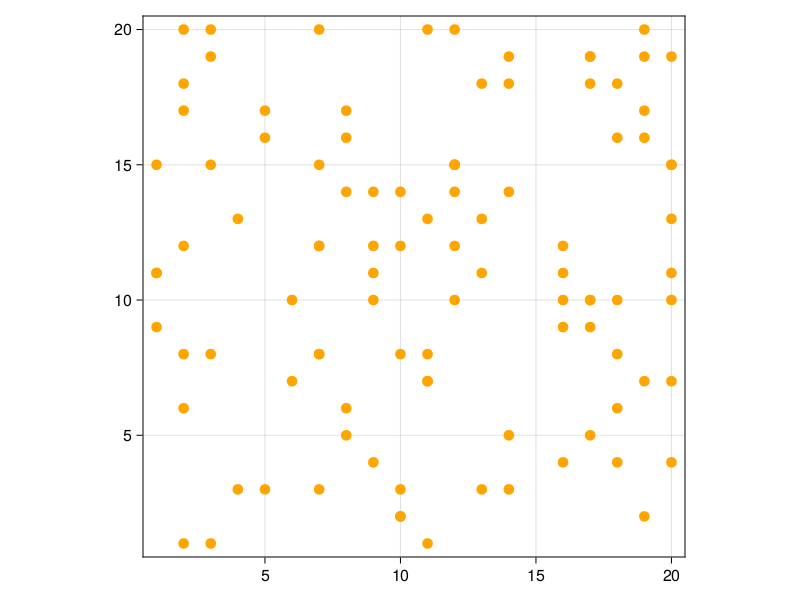

In [47]:
using InteractiveDynamics # where plotting comes from

using GLMakie # this allows videos and interactive apps
model = init_rabbits() # refresh model
rabbitcolor(a) = :orange
rabbitmarker(a) = :circle
fig, = abmplot(model; ac = rabbitcolor, am = rabbitmarker)
fig

giving the stepping functions to the `abmplot` function will allow use to interactive evolve the model!

In [50]:
fig, = abmplot(model; 
    ac = rabbitcolor, am = rabbitmarker,
    agent_step! = rabbit_step!,    
)

fig

## Spring time! (grass dynamics, reproduction dynamics)

Let's now add the grass dynamics, which will introduce more complexity to the model by

- Adding model properties that are spatial fields
- Accessing model properties
- Adding a model step function
- Allowing rabbits to generate more rabbits once they have enough energy

To do this, we first modify the model creation function to add two properties for grass: one that checks if it is fully grown (`Bool`) and a countdown to regrowth (`Int`). They are spatial fields because each cell has its own grass counter!

### 1. Choose the space and 2. Define the agent type
Done
### 3. Define the model

In [51]:
function init_rabbits_grass(; 
        # Rabbit properties:
        energy = 10.0, Δenergy = 5.0, reproduction_prob = 0.1,
        # Grass properties:
        griddims = (20, 20), regrowth_time = 10,
        # General:
        seed = 1234, total_agents = 100, 
    )
    
    space = GridSpace(griddims)
    
    rng = Xoshiro(seed)
    
    # Initialize grass properties
    properties = (
        fully_grown = falses(griddims),
        countdown = rand(rng, 1:regrowth_time, griddims),
        regrowth_time = regrowth_time,
    )
    
    model = AgentBasedModel(Rabbit, space; rng, properties)
    
    for n in 1:total_agents
        add_agent!(model, energy, Δenergy, reproduction_prob)
    end
    return model
end

model = init_rabbits_grass()

StandardABM with 100 agents of type Rabbit
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: fully_grown, countdown, regrowth_time

The grass dynamics are governed by a _model stepping function_ that accepts a single argument (the model) and it evolves the model by one step. Here, this function is about the grass dynamics

In [52]:
function grass_step!(model)
    # iterate over all positions (cells) in the model
    # they are 2-tuples of integers
    for p in positions(model)
        if !model.fully_grown[p[1], p[2]]
            model.countdown[p[1], p[2]] -=1
            if model.countdown[p[1], p[2]] ≤ 0
                model.fully_grown[p[1], p[2]] = true
                model.countdown[p[1], p[2]] = model.regrowth_time
            end
        end
    end
end

grass_step! (generic function with 1 method)

We utilized a nice feature of Agents.jl above: model properties can be accessed with the `.property` syntax, as if they were fields of the model type (they aren't, but Julia allows such nice things ;) ).

### 4. Time evolution of the ABM

We also modify the rabbit dynamics to eat and generate offsprings

In [53]:
function rabbit_step!(rabbit, model)
    randomwalk!(rabbit, model, 1; ifempty = false) # radius 1
    rabbit.energy -= 1 # lose 1 energy per step
    if rabbit.energy ≤ 0
        kill_agent!(rabbit, model)
    end
    # consume a food source if available.
    eat_grass!(rabbit, model)
    # otherwise, it lives and reproduces with some probability.
    if rand(abmrng(model)) ≤ rabbit.reproduction_prob
        reproduce!(rabbit, model)
    end
end

function eat_grass!(rabbit, model)
    # if grass is grown, eat it to gain energy
    if model.fully_grown[rabbit.pos[1], rabbit.pos[2]]
        rabbit.energy += rabbit.Δenergy
        model.fully_grown[rabbit.pos[1], rabbit.pos[2]] = false
        model.countdown[rabbit.pos[1], rabbit.pos[2]] = model.regrowth_time
    end
    
    return
end

function reproduce!(agent, model)
    agent.energy /= 2
    #Create and add agent at the position agent.pos
    add_agent!(agent.pos, model, agent.energy, agent.reproduction_prob, agent.Δenergy)
    return
end

reproduce! (generic function with 1 method)

Alright, so we have now can do:

In [54]:
model = init_rabbits_grass()

StandardABM with 100 agents of type Rabbit
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: fully_grown, countdown, regrowth_time

In [55]:
step!(model, rabbit_step!, grass_step!, 100)
model

StandardABM with 123 agents of type Rabbit
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: fully_grown, countdown, regrowth_time

### 5. Visualize the model and animate its time evolution

Agents seem to reduce in numbers. Let's visualize again to see how the model behaves. We can learn do one more thing during visualization: visualize a spatial property as a heatmap. This is as easy as choosing the `heatarray` argument to be a model property, or a function of the model, like so:

In [56]:
model = init_rabbits_grass()

grasscolor(model) = 1 .- (model.countdown ./ model.regrowth_time)
heatkwargs = (colormap = [:tan4, :green], colorrange = (0,1))

plotkwargs = (;
    ac = "white",
    as = 25,
    #additional keyword arguments propagated to the scatter! call.
    scatterkwargs = (strokewidth = 1.0, strokecolor = :black),
    heatarray = grasscolor,
    heatkwargs = heatkwargs,
)

fig, = abmplot(model; 
    agent_step! = rabbit_step!, model_step! = grass_step!,
    plotkwargs...,
)

fig

# Agents.jl: advanced modelling

## Hungry hungry foxes!

Let's now add foxes into the model, which will introduce even more complexity to the model by

- Adding another agent "type" (not really, see below)
- Adding neighboring agent searches
- Adding two different agent stepping functions depending on the agent "type"
- Agent-dependent plotting of agents

### 1. Choose the space 
Done

### 2. Define the agent type

Rabbits and foxes have indentical _property types_, even if they have different _values_ for the properties. Normally, we would have to make different agent types for the rabbits and the foxes, but here we can cheat the system by doing:

In [21]:
@agent Animal GridAgent{2} begin
    type::Symbol # either `:Rabbit` or `:Fox`
    energy::Float64
    Δenergy::Float64
    reproduction_prob::Float64
end

### 4. Time evolution of the ABM
We'll differentiate between foxes and rabbits on the basis of the animal type. This means that we reform the agent stepping function into:

In [22]:
function animal_step!(animal, model)
    if animal.type == :Rabbit
        rabbit_step!(animal, model)
    elseif animal.type == :Fox
        fox_step!(animal, model)
    end
end

animal_step! (generic function with 1 method)

and we reuse the `rabbit_step!` function from above, but we define a new function for foxes. Foxes are agile and adept hunters of rabbits and therefore, unlike rabbits, they can look for food in a neighborhood around them instead of only the position they are at. We achieve this using the `nearby_agents` function:

In [23]:
function fox_step!(fox, model)
    # move
    randomwalk!(fox, model, 1; ifempty=false)
    # die
    fox.energy -= 1
    if fox.energy < 0
        kill_agent!(fox, model)
        return
    end
    # eat 
    eat_rabbit!(fox, model)
    # reproduce
    if rand(abmrng(model)) <= fox.reproduction_prob
        reproduce!(fox, model)
    end
    return nothing
end

function eat_rabbit!(fox, model)
    # attempt to find a neary rabbit
    for animal in nearby_agents(fox, model)
        if animal.type == :Rabbit # found one!
            kill_agent!(animal, model)
            fox.energy += fox.Δenergy
        end
    end
    return
end            

eat_rabbit! (generic function with 1 method)

Don't forget to update the `reproduce!` function to take into account this new extra field `type`!

In [24]:
function reproduce!(agent, model)
    agent.energy /= 2
    #Create and add agent at the position agent.pos
    add_agent!(agent.pos, model, agent.type, agent.energy, agent.reproduction_prob, agent.Δenergy)
    return
end

reproduce! (generic function with 1 method)

### 3. Define the model

Okay, now let's make a function that creates a model that has both rabbits and foxes!

In [25]:
function init_foxes_rabbits_grass(; 
        # Rabbit properties:
        total_rabbits = 60, 
        rabbit_energy = 10.0, rabbit_Δenergy = 5.0, rabbit_r_prob = 0.30,
        # Fox properties:
        total_foxes = 10,
        fox_energy = 60.0, fox_Δenergy = 30.0, fox_r_prob = 0.06,
        # Grass properties:
        griddims = (20, 20), regrowth_time = 10,
        # General:
        seed = 1234, total_agents = 100, 
    )
    space = GridSpace(griddims)
    rng = Xoshiro(seed)
    
    # Initialize grass properties
    properties = (
        fully_grown = falses(griddims),
        countdown = rand(rng, 1:regrowth_time, griddims),
        regrowth_time = regrowth_time,
    )

    # Use a scheduler that makes rabbits act first
    scheduler = Schedulers.ByProperty(animal -> animal.type == :Rabbit ? 1 : 0)
    model = AgentBasedModel(Animal, space; rng, properties, scheduler)

    for n in 1:total_rabbits
        add_agent!(model, :Rabbit, rabbit_energy, rabbit_Δenergy, rabbit_r_prob)
    end
    for n in 1:total_foxes
        add_agent!(model, :Fox, fox_energy, fox_Δenergy, fox_r_prob)
    end
    return model
end

model = init_foxes_rabbits_grass()

StandardABM with 70 agents of type Animal
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.ByProperty{var"#16#17"}
 properties: fully_grown, countdown, regrowth_time

Notice that we also for the first time changed the model _scheduler_, which schedules which agents act first.

In [26]:
model = init_foxes_rabbits_grass()
step!(model, animal_step!, grass_step!)
model

StandardABM with 71 agents of type Animal
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.ByProperty{var"#16#17"}
 properties: fully_grown, countdown, regrowth_time

### 5. Visualize the model and animate its time evolution

Let's now visualize the time evolution for this model, using a different color and marker for rabbits and foxes

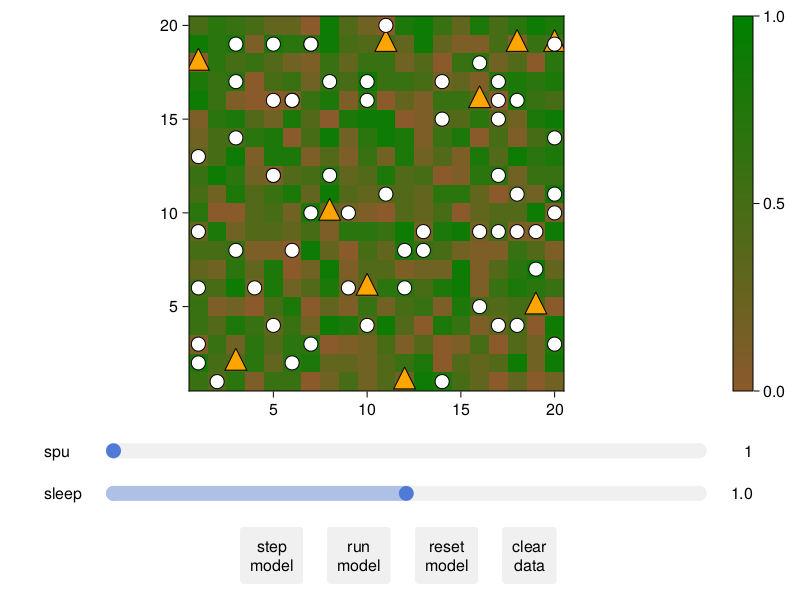

In [27]:
model = init_foxes_rabbits_grass()

animalcolor(animal) = animal.type == :Rabbit ? "white" : "orange"
animalmarker(animal) = animal.type == :Rabbit ? :circle : :utriangle
animalsize(animal) =  animal.type == :Rabbit ? 20 : 30 

plotkwargs = (;
    ac = animalcolor,
    am = animalmarker,
    as = animalsize,
    #additional keyword arguments propagated to the scatter! call.
    scatterkwargs = (strokewidth = 1.0, strokecolor = :black),
    heatarray = grasscolor,
    heatkwargs = heatkwargs,
)

fig, = abmplot(model; 
    agent_step! = animal_step!, model_step! = grass_step!,
    plotkwargs...,
)

fig

## 6. Collecting data

So far so good, but to do actual science one needs to collect data. Thankfully, Agents.jl has a stellar data collection infastructure.

To collect data, we should specify the data we want to collect by providing one standard Julia `Vector` of data-to-collect for agents. Running the model and collecting data while the model runs is done with the `run!` function. The agent data names are given as the keyword `adata` and the model as keyword `mdata` to the function `run!`. This function outputs collected data in the form of a `DataFrame`.

For example, let's set up a basic data collection that collects the number of foxes, rabbits, and the average amount of grass (proportion of fully grown). The grass is a model property, but the number of animals we could get in two ways: (1) by aggregating agent properties or (2) by looping over `allagents` of the model. We'll use (2) for now to keep things simple.

In [28]:
nfoxes(model) = count(a -> a.type == :Fox, allagents(model))
nrabbits(model) = count(a -> a.type == :Rabbit, allagents(model))
ngrass(model) = count(model.fully_grown)

# `mdata` is functions of model to output
mdata = [nfoxes, nrabbits, ngrass]

3-element Vector{Function}:
 nfoxes (generic function with 1 method)
 nrabbits (generic function with 1 method)
 ngrass (generic function with 1 method)

To actually collect these data we call `run!` with the amount of steps to step and collect data for

In [29]:
model = init_foxes_rabbits_grass()

adf, mdf = run!(model, animal_step!, grass_step!, 100; mdata)
mdf

Row,step,nfoxes,nrabbits,ngrass
,Int64,Int64,Int64,Int64
1,0,10,60,0
2,1,10,61,34
3,2,10,72,75
4,3,10,99,101
5,4,10,115,123
6,5,10,126,147
7,6,11,99,167
8,7,12,76,180
9,8,14,66,204


This is a `DataFrame`, the standard Julia type used for tabular data and data analysis. DataFrames.jl is an absolutely incredible package, but it needs to be learned independently of this tutorial!

In any case, let's wrap this `run!` call to a function that collects and then plots data!

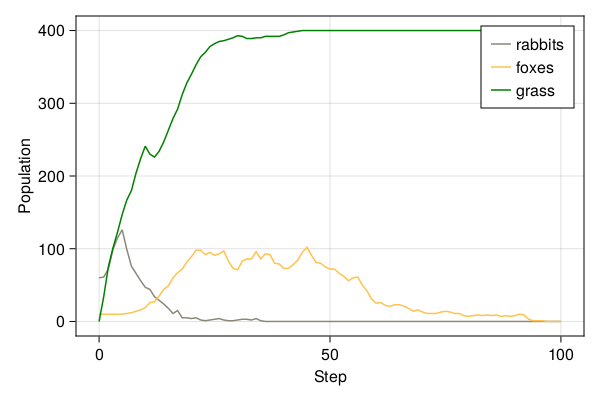

In [30]:
function plot_population_timeseries(; kwargs...)
    model = init_foxes_rabbits_grass(; kwargs...)
    adf, mdf = run!(model, animal_step!, grass_step!, 100; mdata)

    figure = Figure(resolution = (600, 400))
    ax = figure[1, 1] = Axis(figure; xlabel = "Step", ylabel = "Population")

    lines!(ax, mdf.step, mdf.nrabbits, color = :cornsilk4, label = "rabbits")
    lines!(ax, mdf.step, mdf.nfoxes, color =  RGBAf(1.0, 0.76, 0.3), label = "foxes")
    lines!(ax, mdf.step, mdf.ngrass, color = :green, label = "grass")
    axislegend(ax)
    figure
end

plot_population_timeseries()

# ~ Exercises ~

## 1. Exploring the rabbit fox model

For some starting configurations the rabbit-fox model leads to partial or total species death. Continue from the above function `plot_population_timeseries` and play around with different keywords (starting parameters for the model). Record one set of parameters where both rabbits and foxes survive and oscillate around equilibrium values, on set of parameters where foxes die out but rabbits survive, and one set of parameters where both species become extinct.

## 2. Wright-Fisher model

### Neutral model
Create an agent-based model for the neutral Wright-Fisher model. This population genetics model describes the evolution of a fixed size population that undergoes genetic drift. 

* The model will have no spatial property. Therefore, the agents are defined as `NoSpaceAgent`.
* The population is composed of `n` haploid individuals. The main property of each agent is `trait`, which will represent the fitness of the agent on a range from 0 to 1.
* The agents will be activated randomly in the model. Therefore, we need to seed the simulation to make it reproducible. In addition, we would like for our model to be initialized with the property `population_size`, in order to freely modify the amount of individuals in the population.
* At each generation, `n` offsprings replace the parents. This means that `n` offspring are sampled with replacement from the parent generation.
* The objective of the simulation is to plot the evolution of the average trait over time.

### Model with selection
Create an agent-based model for the Wright-Fisher model with selection. This means that the model now samples individuals according to their trait values (we assume that the inviduals' fitness is correlated to their trait values).

-----
*Tip: use the function `sample!`from Agents.jl*

`sample!(model::ABM, n [, weight]; kwargs...)`

It replaces the agents of the model with a random sample of the current agents with size `n`.
* `weight`: Symbol (agent field) or function (input agent output real number) to weight the sampling. This means that the higher the weight of the agent, the higher the probability that this agent will be chosen in the new sampling.

## 3. Spatial Rock-Paper-Scissors

Create an agent-based model for the spatial rock-paper-scissors game.

The agent-based model simulation describes the evolution of 3 competing strategies ("Rock", "Paper" and "Scissors") that interact through cyclic, nonhierarchical interactions.
To be more precise, the interactions follow a Rock-Paper-Scissors construction:
* Rock + Scissors --> Rock
* Scissors + Paper --> Scissors
* Paper + Rock --> Paper

Agents interact with their nearest 4 neighbours through selection or reproduction, both of which reactions occur as Poisson processes at rates $\sigma$ and $\mu$.

In addition, the model explores the effect of mobility on the diversity of the population via the exchange rate $\epsilon$.

* Selection reflects cyclic dominance: Rock --> Scissors --> Paper --> Rock
* Reproduction of strategies is only allowed on empty neighbouring sites, to mimic a finite carrying capacity of the system
* Mobility is represented via $\epsilon$, this exchange rate represent the likelihood of agents to swap position with a neighbouring individual or hop onto an empty neighbouring site.

![Spatial RPS instructions](SpatialRPS_instructions.png)

Whether selection, reproduction or mobility occurs is computed according to the reaction rates using the [Gillespie algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm).

Explore the system's evolution for different exchange rate values.

